In [1]:
%pylab inline
import scipy.linalg as linalg
from scipy.interpolate import RectBivariateSpline
#from scipy.interpolate import interp2d

#from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Importing Eperimental data

actTime =[]

count1 = 0
linenum1 = 0
actgridlist = []

in_file1 = open('Trial1-Exp-plateplots', 'r')

for line in in_file1:
    if linenum1 == 0:
        stringtime1 = line.rstrip('\n')
        time1 = float(stringtime1)
        actTime.append(time1)
        linenum1 = 1
    else:
        actgrid = zeros([10,10])
        actstringtemps = line.rstrip('\n')
        acttemps_list = actstringtemps.split()
        
        if len(acttemps_list) != 100:
            actTime.pop()
        
        else:
            for j in range(10):
                for k in range(10):
                    actgrid[j,k] = acttemps_list[j*10+k]
            actgridlist.append(actgrid)
        linenum1 = 0

In [3]:
Tbound = 0

#Length of the plate in meters for x and y directions
Lx = .30 # m
Ly = .30 # m

#Number of indices to split the rows and collumns into 
Nx = 120 #Lx / Delta
Ny = 120 #Ly / Delta

#Spacing for each indice
Delta = Lx / Nx #m


In [4]:
#Room Temp
T0 = 22.69


Nplates = 1001


#Themal Properties of aluminum
k = 237 #thermal conductivity of Aluminum. W/m*K
c = 898.7 #specific heat of aluminum J/Kg*K
row = 2700 #density of aluminum Kg/m^3
dt = .01 #Time step, seconds

n1 = (k * dt / (row * c * Delta**2)) #eta for stable solution, eta has to be <.25 due to 2-D, n1=.244


tvect = zeros(Nplates, float)

Thistory1 = zeros((Nplates, Nx), float)

In [5]:
def makegrid(Lx, Ly, Delta):
    """This function makes a x and y grid with given lengths and a set change increment.
        
    Args:
        Lx (float): length of the x side of the array
        Ly (float): length of the y side of the array
        Delta (float): increment dividing the length into sections
    Returns:
        array: A matrix of x values
        array: A matrix of y values
        list: A list of x values
        list: A list of y values
    """
    #create Zlist
    xlist = arange(0, Lx, Delta)
    ylist = arange(0, Ly, Delta)
    xgrid, ygrid = meshgrid(xlist, ylist)
    #mesh grid with Zlist
    return xgrid, ygrid, xlist, ylist#return Zgrid

In [6]:
#DON'T USE THIS ONE. USE PLATECOND2

def platecond(T0, Tplate, fixed, Ny):
    """This function sets the initial conditions for the simulation with a 6cm square in middle of the plate.
        
    Args:
        T0 (float): room temp
        Tplate (float): matirx of temperatures
        fixed (float): matrix boolean variables setting boundaries on an array
        Ny (float): number of indices on the y side of the matrix. (same number of indices on x side)
    Returns:
        float: A matrix of initial temperature conditions in place for the simulation
        float: A fixed matrix setting the areas where the temperatures of the simulation are to True
    """
    
    for i in range(Ny):
        #if i == 2:
            #for n in range(3,7):
                #add in z range
                    #Tplate[n,i] = -T0
                    #fixed[n,i] = True
                    #add in z indice
        if i >=48 and i <=72:
            for n in range(0,120):
                if n in range(48,73):
                    #add in z range
                    Tplate[n,i] = T0
                    #fixed[n,i] = True  
                    #add in z indice
                else:
                    Tplate[n,i] = T0
                
        else:
            for n in range(Nx):
                Tplate[n,i] = T0
                #fixed[n,i] = False
                
    for i in range(Nx):
        #Bottom row
        #Tplate[-1, i] = Vbound       Already set to zero
        fixed[-1, i] = True
        #Top row
        #Tplate[0, i] = Vbound        Already set to zero
        fixed[0, i] = True
        
        #add in a z indice
    
    for i in range(Ny):
        #left side
        fixed[i, 0] = True
        #Right side
        fixed[i, -1] = True
        
        #add in a z indice
        
    # set boundry conditions for z components of matrix
    
    return Tplate, fixed

In [7]:
#For a 6cm square in center of plate
#Simulation temps at T=0 are equal to the Experimental temps at T = 0

def platecond2(T0, Tplate, fixed, Ny):
    """This function sets the initial conditions for the simulation with a 6cm square in middle of the plate.
        
    Args:
        T0 (float): room temp
        Tplate (float): matirx of temperatures
        fixed (float): matrix boolean variables setting boundaries on an array
        Ny (float): number of indices on the y side of the matrix. (same number of indices on x side)
    Returns:
        float: A matrix of initial temperature conditions in place for the simulation
        float: A fixed matrix setting the areas where the temperatures of the simulation are to True
    """
    
    actindex = 0
   
    #2-D interpolate to find the temperature of the experiment at the current simulation index
    xsensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
    ysensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
    
    xlist = arange(0, Lx, Delta)
    ylist = arange(0, Ly, Delta)
    
    Interp_Spline = RectBivariateSpline(xsensors, ysensors, actgridlist[actindex])
    sensortemps = Interp_Spline(xlist, ylist)
    
    for j in range(Ny):
        for i in range(Nx):
            Tplate[i, j] = sensortemps[i, j]
    
    #Create the fixed matrix
    for i in range(Nx):
        #Bottom row
        fixed[-1, i] = True
        #Top row
        fixed[0, i] = True
    
    for i in range(Ny):
        #left side
        fixed[i, 0] = True
        #Right side
        fixed[i, -1] = True
        
    
    return Tplate, fixed

In [8]:
#DON'T USE THIS ONE!!! USE NEXTSTEP2

def nextstep1(Tplate, fixed, Ny, Nx, time):
    """This function calculates the next matrix of Temperatures.
        
    Args:
        Tplate (float): matirx of temperatures
        fixed (float): matrix boolean variables setting boundaries on an array
        Nx (float): number of indices on the x side of the matrix
        Ny (float): number of indices on the y side of the matrix
        time (float): current time in the simulation
    Returns:
        float: A matrix of the next set of temperatures
    """
    actindex = 0
    actualtime = actTime[actindex]

    while actualtime < time:
        actindex += 1
        actualtime = actTime[actindex]

    #Interpolate the actual temps to find the temperature of the experiment at the current simulation time
    interpactualplatetemps = actgridlist[actindex] + ((actgridlist[actindex - 1] - actgridlist[actindex])*(time - actTime[actindex]) / (actTime[actindex - 1]-actTime[actindex]))
    
    #2-D interpolate to find the temperature of the experiment at the current simulation index
    xsensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
    ysensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
    
    #xgrid, ygrid, xlist, ylist = makegrid(Lx, Ly, Delta)
    xlist = arange(0, Lx, Delta)
    ylist = arange(0, Ly, Delta)
    
    Interp_Spline = RectBivariateSpline(xsensors, ysensors, interpactualplatetemps)
    sensortemps = Interp_Spline(xlist, ylist)
    
    
    #Creating Tplatenext
    Tplatenext = zeros((Ny, Nx), float)
    #add in z indice
    for j in range(Ny):
        for i in range(Nx):
            #forloop for the z range
            if fixed[i,j] == False:
                if i >=48 and i <=72 and j >=48 and j <=72:
                    Tplatenext[i, j] = sensortemps[i, j]
                
                else:
                    Tplatenext[i, j] = Tplate[i,j] + n1 * ((Tplate[i + 1, j] + Tplate[i - 1, j] - 2 * Tplate[i,j]) + (Tplate[i, j + 1] + Tplate[i, j - 1] - 2 * Tplate[i,j]))
                    #add in z indice
                
                
                
            if fixed[i,j] == True:
                Tplatenext[i, j] = Tplate[i,j]
                #add in z indice
    return Tplatenext

In [9]:
#### Sets the boundaries and the stencil equal to the experimental values
# For a 6cm sqaure mold set in the center of the plate.

def nextstep2(Tplate, fixed, Ny, Nx, time):
    """This function calculates the next matrix of Temperatures.
        
    Args:
        Tplate (float): matirx of temperatures
        fixed (float): matrix boolean variables setting boundaries on an array
        Nx (float): number of indices on the x side of the matrix
        Ny (float): number of indices on the y side of the matrix
        time (float): current time in the simulation
    Returns:
        float: A matrix of the next set of temperatures
    """
    actindex = 0
    actualtime = actTime[actindex]
    #Loop to find the indices of the experiment that are right before and after the current time of the simulation.
    while actualtime < time:
        actindex += 1
        actualtime = actTime[actindex]

    #Interpolate the actual temps to find the temperature of the experiment at the current simulation time
    interpactualplatetemps = actgridlist[actindex] + ((actgridlist[actindex - 1] - actgridlist[actindex])*(time - actTime[actindex]) / (actTime[actindex - 1]-actTime[actindex]))
    
    #2-D interpolate to find the temperature of the experiment at the current simulation index
    xsensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
    ysensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
    
    xlist = arange(0, Lx, Delta)
    ylist = arange(0, Ly, Delta)
    
    Interp_Spline = RectBivariateSpline(xsensors, ysensors, interpactualplatetemps)
    sensortemps = Interp_Spline(xlist, ylist)
    
    
    #Creating Tplatenext
    Tplatenext = zeros((Ny, Nx), float)
    for j in range(Ny):
        for i in range(Nx):
            if fixed[i,j] == False:
                if i >=48 and i <=72 and j >=48 and j <=72:
                    Tplatenext[i, j] = sensortemps[i, j]
                
                else:
                    Tplatenext[i, j] = Tplate[i,j] + n1 * ((Tplate[i + 1, j] + Tplate[i - 1, j] - 2 * Tplate[i,j]) + (Tplate[i, j + 1] + Tplate[i, j - 1] - 2 * Tplate[i,j]))
                
            if fixed[i,j] == True:
                Tplatenext[i, j] = sensortemps[i,j]
    return Tplatenext

# Simulation

In [42]:
biggestchange = 1
count = 0
currentplate = 0 #index for the current of the history matrix that needs to be filled
currenttime = actTime[0]

Tnum1 = zeros((Ny, Nx), float)
fixed = zeros((Ny, Nx), bool)

Tnum1, fixed = platecond2(T0, Tnum1, fixed, Ny)

Thistory1 = []
Thistory1.append(Tnum1)
tvect[currentplate] = currenttime

currentplate += 1
currenttime += dt

#Loop until the current time greater than 300 seconds.
while currenttime <= 300:
    Tprev = Tnum1.copy()
    
    #pass over entire matrix, resetting values according to the algorithm.
    Tnumnext1 = nextstep2(Tprev, fixed, Ny, Nx, currenttime)
    Tnum1 = Tnumnext1
    
    biggestchange = amax(abs(Tprev - Tnum1)) / T0
    
    currenttime += dt
    count += 1
    
    #store Tnum into the history matrix
    if count % 240 == 0:
        Thistory1.append(Tnum1)
        tvect[currentplate] = currenttime
        
        currentplate += 1
        if currentplate == Nplates:
            break
    
        print(count, currenttime)
    #if count > 100:
        #break

240 9.505000028610178
480 11.905000028610127
720 14.305000028610076
960 16.70500002861015
1200 19.105000028610526
1440 21.5050000286109
1680 23.905000028611276
1920 26.30500002861165
2160 28.705000028612027
2400 31.1050000286124
2640 33.505000028612244
2880 35.90500002861177
3120 38.30500002861129
3360 40.70500002861081
3600 43.105000028610334
3840 45.50500002860986
4080 47.90500002860938
4320 50.3050000286089
4560 52.705000028608424
4800 55.10500002860795
5040 57.50500002860747
5280 59.90500002860699
5520 62.305000028606514
5760 64.70500002860653
6000 67.10500002860776
6240 69.50500002860899
6480 71.90500002861022
6720 74.30500002861145
6960 76.70500002861267
7200 79.1050000286139
7440 81.50500002861513
7680 83.90500002861636
7920 86.30500002861758
8160 88.70500002861881
8400 91.10500002862004
8640 93.50500002862127
8880 95.9050000286225
9120 98.30500002862372
9360 100.70500002862495
9600 103.10500002862618
9840 105.5050000286274
10080 107.90500002862863
10320 110.30500002862986
10560

# Plotting some results from the simulation

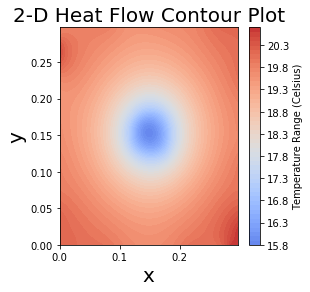

In [43]:
xgrid, ygrid, xlist, ylist = makegrid(Lx, Ly, Delta)

fig, ax1 = plt.subplots(1, 1, figsize = plt.figaspect(1))
tempplot = contourf(xgrid, ygrid, Thistory1[-1], 50, cmap = cm.coolwarm)


tempbar = colorbar(tempplot)
tempbar.set_label('Temperature Range (Celsius)')
clim(15,21)

ax1.set_xlabel('x', fontsize=20)
ax1.set_ylabel('y', fontsize=20)
ax1.set_title('2-D Heat Flow Contour Plot', fontsize=20)

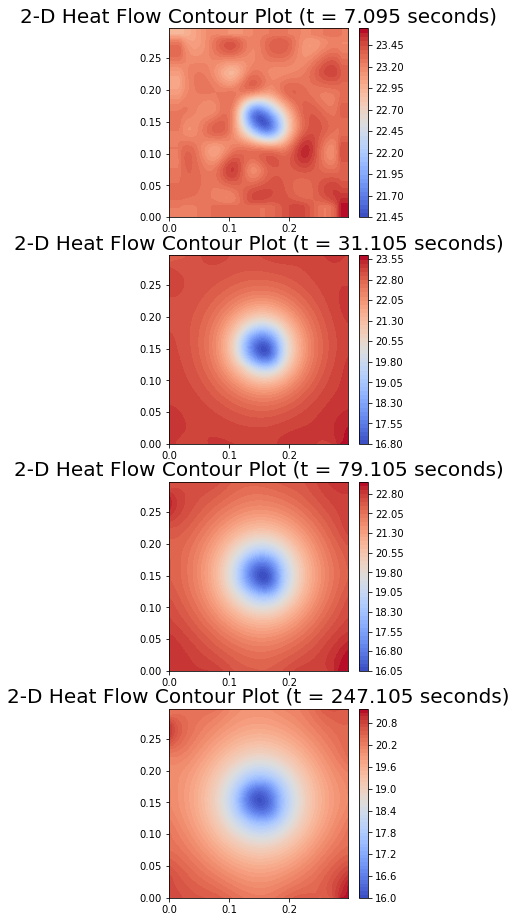

In [44]:
xgrid, ygrid, xlist, ylist = makegrid(Lx, Ly, Delta)
#v = linspace(0,10,10, endpoint=True)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = plt.figaspect(4))

plot1index = 0
plot2index = 10
plot3index = 30
plot4index = 100



plot1 = ax1.contourf(xgrid, ygrid, Thistory1[plot1index], 50, cmap = cm.coolwarm)
plot2 = ax2.contourf(xgrid, ygrid, Thistory1[plot2index], 50, cmap = cm.coolwarm)
plot3 = ax3.contourf(xgrid, ygrid, Thistory1[plot3index], 50, cmap = cm.coolwarm)
plot4 = ax4.contourf(xgrid, ygrid, Thistory1[plot4index], 50, cmap = cm.coolwarm)

#ax1.set_xlabel('x', fontsize=20)
#ax1.set_ylabel('y', fontsize=20)
ax1.set_title('2-D Heat Flow Contour Plot (t = %3.3f seconds)' %tvect[plot1index], fontsize=20)
plt.colorbar(plot1, ax=ax1)

#ax2.set_xlabel('x', fontsize=20)
#ax2.set_ylabel('y', fontsize=20)
ax2.set_title('2-D Heat Flow Contour Plot (t = %3.3f seconds)' %tvect[plot2index], fontsize=20)
plt.colorbar(plot2, ax=ax2)

#ax3.set_xlabel('x', fontsize=20)
#ax3.set_ylabel('y', fontsize=20)
ax3.set_title('2-D Heat Flow Contour Plot (t = %3.3f seconds)' %tvect[plot3index], fontsize=20)
plt.colorbar(plot3, ax=ax3)

#ax4.set_xlabel('x', fontsize=20)
#ax4.set_ylabel('y', fontsize=20)
ax4.set_title('2-D Heat Flow Contour Plot (t = %3.3f seconds)' %tvect[plot4index], fontsize=20)
plt.colorbar(plot4, ax=ax4)

# Interpolation Code

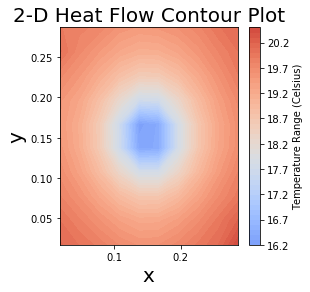

In [45]:
xsensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
ysensors = [.017, .047, .077, .107, .137, .167, .197, .227, .257, .287]
xsensorgrid, ysensorgrid = meshgrid(xsensors, ysensors)

xgrid, ygrid, xlist, ylist = makegrid(Lx, Ly, Delta)

Interp_Spline = RectBivariateSpline(xlist, ylist, Thistory1[-1])
sensortemps = Interp_Spline(xsensors, ysensors)


fig, ax1 = plt.subplots(1, 1, figsize = plt.figaspect(1))
tempplot = contourf(xsensorgrid, ysensorgrid, sensortemps, 50, cmap = cm.coolwarm)

tempbar = colorbar(tempplot)
tempbar.set_label('Temperature Range (Celsius)')
clim(15,21)
ax1.set_xlabel('x', fontsize=20)
ax1.set_ylabel('y', fontsize=20)
ax1.set_title('2-D Heat Flow Contour Plot', fontsize=20)

# Exporting the interpolation data and its corresponding time to a csv file

In [46]:
filename = input('Name of File? ') #needs to be csv, ie. filename.csv
file_object  = open(filename, 'w')

count = 0

for item in Thistory1:
    csvdata =[]
    templist = []
    Interp_Spline = RectBivariateSpline(xlist, ylist, Thistory1[count])
    sensortemps = Interp_Spline(xsensors, ysensors)
    #csvdata.append(tvect[count])
    #csvdata.append(sensortemps)
    time = str(tvect[count])
    file_object.write(time + '\n')
    
    for row in sensortemps:
        for num in row:
            temp = str(num)
            file_object.write(temp + ' ')
        
    count += 1
    file_object.write('\n')
    
    #file_object.write(time)
    #file_object.write(sensortemps)
    
file_object.close()

Name of File? Trial1-simulationdata-3.csv
